In [820]:
import numpy as np
import math

In [821]:
def Pi(x: np.array):
    """
    Converts homogeneous to inhomogeneous coordinates
    Args:
        x (np.array) homogeneous coordinate

    Return:
        np.array converted inhomogeneous coordinate
    """

    return x[:-1] / x[-1]


def Piinv(x: np.array):
    """
    Converts inhomogeneous to homogeneous coordinates

    Args:
        x (np.array) inhomogeneous coordinate

    Return:
        np.array converted homogeneous coordinate
    """
    if x.ndim == 1:
        return np.concatenate((x, np.ones(1)))
    return np.vstack((x, np.ones((1, x.shape[1]))))

In [822]:
def skew(x: np.array):
    """
    This function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)
    https://stackoverflow.com/questions/36915774/form-numpy-array-from-possible-numpy-array

    Args:
        x (np.array): 1x3 matrix

    Return:
        s (np.array): 3x3 skew symmetrix matrix for cross product
    """
    vector = x.ravel()
    s = np.asarray(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )
    return s

## Ex 4.1

In [823]:
R = np.asarray([[np.sqrt(0.5), -np.sqrt(0.5), 0], [np.sqrt(0.5), np.sqrt(0.5), 0], [0, 0, 1]])
t = np.asarray([0, 0, 10]).reshape(3, 1)
K = np.asarray([[1000, 0, 960], [0, 1000, 540], [0, 0, 1]])
P = K @ np.concatenate((R, t), axis=1)
P

array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
         9.60000000e+03],
       [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
         5.40000000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+01]])

In [824]:
from itertools import product

# Generate all combinations of (i, j, k)
world_points = np.asarray(list(product([0, 1], repeat=3)))

print("All 8 world_points:")
print(world_points)
world_points = Piinv(world_points.reshape(3, -1))
world_points

All 8 world_points:
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]


array([[0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

In [825]:
image_points = P @ world_points
image_points.shape

(3, 8)

## Ex 4.2

In [826]:
def pest(Q: np.array, q: np.array):
    """
    Find projection matrix using DLT
    Args:
        Q (np.array): homogeneous real world points
        q (np.array): homogeneous image points

    Return:
        P (np.array): projection matrix from real to image
    """
    # Ensure Q and q are in homogeneous coordinates (3xN)
    A = []
    if Q.shape[0] == 2:
        Q = Piinv(Q)
    if q.shape[0] == 2:
        q = Piinv(q)
    num_points = Q.shape[1]
    for i in range(num_points):
        q_no_scale = q[:, i] / q[-1][i]
        q_skew = skew(q_no_scale.reshape(1, 3))
        B_i = np.kron(Q[:, i].T, q_skew)
        A.append(B_i)
    B = np.vstack(A)
    U, S, VT = np.linalg.svd(B)
    ## Important
    P = VT[-1, :].reshape(4, 3).T
    return P

In [827]:
calculated = pest(world_points, image_points)
scaled = calculated * np.linalg.norm(P) / np.linalg.norm(calculated)
scaled, P

(array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 2.40289311e-12,  4.23418666e-12,  1.00000000e+00,
          1.00000000e+01]]),
 array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          1.00000000e+01]]))

In [828]:
np.linalg.norm(P - scaled) / world_points.shape[1]

6.931622180024931e-10

## Checkerboard calibration

In [829]:
def checkerboard_points(n: int, m: int):
    """
    Generate a checkerboard of points from dimensions n and m
    Args:
        n (int): number of rows
        m (int): number of cols

    Return:
        board (np.array): checkerboard points
    """
    A = []
    for i in range(n):
        for j in range(m):
            A.append([i - (n-1)//2, j - (m-1)//2, 0])
    board = np.vstack(A).T
    return board
checkerboard =  checkerboard_points(4, 4)
checkerboard.shape, checkerboard , checkerboard.T


((3, 16),
 array([[-1, -1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2],
        [-1,  0,  1,  2, -1,  0,  1,  2, -1,  0,  1,  2, -1,  0,  1,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[-1, -1,  0],
        [-1,  0,  0],
        [-1,  1,  0],
        [-1,  2,  0],
        [ 0, -1,  0],
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        [ 1, -1,  0],
        [ 1,  0,  0],
        [ 1,  1,  0],
        [ 1,  2,  0],
        [ 2, -1,  0],
        [ 2,  0,  0],
        [ 2,  1,  0],
        [ 2,  2,  0]]))

## Ex 4.4

In [830]:
from scipy.spatial.transform import Rotation

In [831]:
n, m = 10, 20
checkerboard = checkerboard_points(n, m)

min_x = np.min(checkerboard[0, :])
max_x = np.max(checkerboard[0, :])
min_y = np.min(checkerboard[1, :])
max_y = np.max(checkerboard[1, :])

corners = np.array([
    [min_x, min_y, 0],  # Top-left
    [min_x, max_y, 0],  # Top-right
    [max_x, min_y, 0],  # Bottom-left
    [max_x, max_y, 0]   # Bottom-right
])
Q_corners = corners.T
Q_corners.shape, Q_corners

((3, 4),
 array([[-4, -4,  5,  5],
        [-9, 10, -9, 10],
        [ 0,  0,  0,  0]]))

In [832]:
R_a = Rotation.from_euler("xyz", [np.pi / 10, 0, 0]).as_matrix()
R_b = Rotation.from_euler("xyz", [0, 0, 0]).as_matrix()
R_c = Rotation.from_euler("xyz", [-np.pi / 10, 0, 0]).as_matrix()
Q_a = R_a @ checkerboard
Q_b = R_b @ checkerboard
Q_c = R_c @ checkerboard
Q_omega = Rotation.from_euler("xyz", [0, 0, 0]).as_matrix() @ checkerboard

Q_a.shape, Q_b.shape, Q_c.shape, Q_omega.shape

((3, 200), (3, 200), (3, 200), (3, 200))

In [833]:
## Q_omega is the base checkerboard, meaning that it has no transform and we assume that it is flat
# Therefore Z for Q_omega is 0
Q_omega[:, :10]

array([[-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
       [-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

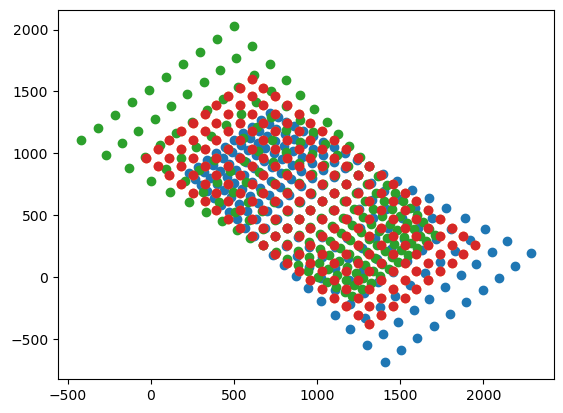

In [834]:
qa = P @ Piinv(Q_a)
qb = P @ Piinv(Q_b)
qc = P @ Piinv(Q_c)
qomega = P @ Piinv(Q_omega)
qa_inhomo = Pi(P @ Piinv(Q_a))
qb_inhomo = Pi(P @ Piinv(Q_b))
qc_inhomo = Pi(P @ Piinv(Q_c))
qomega_inhomo =Pi(qomega)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(
    qa_inhomo[0],
    qa_inhomo[1],
)
ax.scatter(
    qb_inhomo[0],
    qb_inhomo[1],
)
ax.scatter(
    qc_inhomo[0],
    qc_inhomo[1],
)
ax.scatter(
    qomega_inhomo[0],
    qomega_inhomo[1],
)

plt.show()

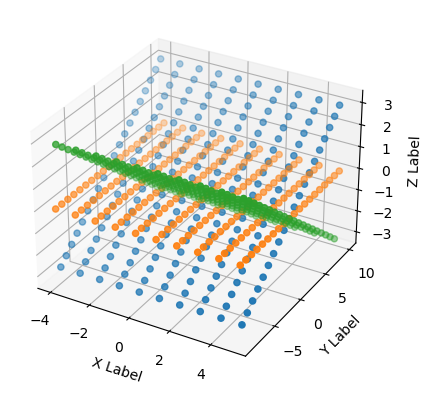

In [835]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_a[0], Q_a[1], Q_a[2])
ax.scatter(Q_b[0], Q_b[1], Q_b[2])
ax.scatter(Q_c[0], Q_c[1], Q_c[2])

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")

plt.show()

In [836]:
image_points = P @ Piinv(checkerboard)
image_points.shape

(3, 200)

## Ex 4.5

In [837]:
def hest(q1: np.array, q2: np.array):
    """
    Obtains estimated homography using linear algorithm

    Args:
        q1 (np.array): first set of points in 2D homogeneous coordinates
        q2 (np.array): second set of points in 2D homoegeneous coordinates

    Return:
        H (np.array): Estimated homography matrix
    """
    A = []
    # Ensure q1 and q2 are in homogeneous coordinates (3xN)
    if q1.shape[0] == 2:
        q1 = Piinv(q1)
    if q2.shape[0] == 2:
        q2 = Piinv(q2)
    num_points = q1.shape[1]
    for i in range(num_points):
        q2_skew = skew(q2[:, i])
        B_i = np.kron(
            q1[:, i].reshape(1, 3),
            q2_skew,
        )
        A.append(B_i)
    B = np.vstack(A)
    U, S, VT = np.linalg.svd(B)
    H = VT[-1, :].reshape(3, 3).T
    return H

In [838]:
Q_omega.shape

(3, 200)

In [839]:
def estimateHomographies(Q_omega: np.array, qs: np.array):
    """
        Estimate a series of homographies between sets of corresponding points
        Args:
            Q_omega (np.array): Original un-transformed checkerboard points in 3D homogeneous coordinate
            qs (np.array): a list of arrays, each element in the list containing 3D points projected to the image plane from different views

        Return:
            H_all (np.array): list of homography between lists of corresponding points
    """
    if Q_omega.shape[0] == 3:
        Q_omega = Piinv(Q_omega)
    # Assume that the z=0 in the world for Q_omega
    # Remove z axis
    Q_omega = np.vstack((Q_omega[:-2], Q_omega[-1]))
    num_sets = qs.shape[0]
    H_all = []
    for i in range(num_sets):
        set_q = qs[i, :]
        if set_q.shape[0] == 2:
            set_q = Piinv(set_q)
        assert set_q.shape == Q_omega.shape
        H_all.append(hest(Q_omega, set_q))
    return np.array(H_all)

In [840]:
qs = np.stack([qa, qb, qc], axis=0)
qs.shape, Q_omega.shape, qs
H_all = estimateHomographies(Q_omega, qs)
H_all.shape

(3, 3, 3)

In [841]:
Q_b.shape

(3, 200)

In [842]:
Q_test = Piinv(Q_b)
Q_b_no_z = np.vstack((Q_test[:-2], Q_test[-1]))
H = hest(Q_b_no_z, qb)
assert H.all() ==  H_all[-2].all()
error_qb = np.linalg.norm(Pi(H_all[-2] @ Q_b_no_z) - Pi(qb))
error_qb

1.2744546836068955e-09

In [843]:
H_all.shape, H_all

((3, 3, 3),
 array([[[ 6.37147183e-02, -3.38657193e-02,  8.65019701e-01],
         [ 6.37147183e-02,  7.56322486e-02,  4.86573582e-01],
         [-2.61045647e-16,  2.78443529e-05,  9.01062188e-04]],
 
        [[ 6.36748702e-02, -6.36748702e-02,  8.64478704e-01],
         [ 6.36748702e-02,  6.36748702e-02,  4.86269271e-01],
         [-1.16557687e-17, -8.33600465e-18,  9.00498650e-04]],
 
        [[-6.36246069e-02,  8.72033708e-02, -8.63796306e-01],
         [-6.36246069e-02, -4.54959117e-02, -4.85885422e-01],
         [-1.41483036e-17,  2.78049727e-05, -8.99787819e-04]]]))

## Ex 4.6

In [844]:
def generate_vi(homography, alpha, beta):
    """
    Generate the 1x6 vector vi^(alpha,beta) from homography elements.

    Args:
        homography (np.array): 3x3 homography matrix H_i
        alpha (int): row index for the first part (0, 1, or 2, corresponding to 1α, 2α, 3α)
        beta (int): row index for the second part (0, 1, or 2, corresponding to 1β, 2β, 3β)

    Returns:
        vi (np.array): 1x6 numpy array representing v_i^(alpha,beta)
    """
    # H(RC) is the element in row r and colc
    H1_alpha = homography[0, alpha]
    H2_alpha = homography[1, alpha]
    H3_alpha = homography[2, alpha]
    H1_beta = homography[0, beta]
    H2_beta = homography[1, beta]
    H3_beta = homography[2, beta]

    # [H_i^(1α)H_i^(1β), H_i^(1α)H_i^(2β) + H_i^(2α)H_i^(1β), H_i^(2α)H_i^(2β),
    #  H_i^(1α)H_i^(3β) + H_i^(3α)H_i^(1β), H_i^(2α)H_i^(3β) + H_i^(3α)H_i^(2β),
    #  H_i^(3α)H_i^(3β)]

    vi = np.array(
        [
            H1_alpha * H1_beta, 
            H1_alpha * H2_beta + H2_alpha * H1_beta, 
            H2_alpha * H2_beta,
            H3_alpha * H1_beta + H1_alpha * H3_beta,
            H3_alpha * H2_beta + H2_alpha * H3_beta,
            H3_alpha * H3_beta
        ]
    )

    return vi

In [845]:
# h1 is the first column in the homography matrix
h1 = H_all[2][:, 0]
B_true = np.linalg.inv(K).T @ np.linalg.inv(K)

b_true = np.asarray(
    [B_true[0][0], B_true[0][1], B_true[1][1], B_true[0][2], B_true[1][2], B_true[2][2]]
).T
generate_vi(H_all[2], 0, 0) @ b_true, h1.T @ B_true @ h1

(8.096181194855698e-09, 8.0961811948557e-09)

In [846]:
def estimate_b(Hs: np.array):
    """
    Estimate b from a list of homographies
    Args:
        Hs (np.array): list of homographies

    Return:
        b (np.array): vector with variables from symmetric inv(K.T) @ inv(K)
    """
    V = []
    num_homographies = Hs.shape[0]
    for i in range(num_homographies):
        # Add constraints
        homography = Hs[i, :, :]
        V.append(generate_vi(homography, 0, 1))
        V.append(generate_vi(homography, 0, 0) - generate_vi(homography, 1, 1))
    V_stack = np.vstack(V)
    U, S, VT = np.linalg.svd(V_stack)
    b = VT[-1, :]
    return b

In [847]:
estimate_b(H_all)

array([-4.51834392e-07,  7.49378795e-20, -4.51834392e-07,  4.33761016e-04,
        2.43990572e-04, -9.99999876e-01])

In [848]:
estimated_b = estimate_b(H_all)
estimated_b, b_true

(array([-4.51834392e-07,  7.49378795e-20, -4.51834392e-07,  4.33761016e-04,
         2.43990572e-04, -9.99999876e-01]),
 array([ 1.0000e-06,  0.0000e+00,  1.0000e-06, -9.6000e-04, -5.4000e-04,
         2.2132e+00]))

In [849]:
calculated_b_normalized = estimated_b / np.linalg.norm(estimated_b)
b_true_normalized = b_true / np.linalg.norm(b_true)
diff = calculated_b_normalized - b_true_normalized
calculated_b_normalized, b_true_normalized, np.linalg.norm(diff)

(array([-4.51834392e-07,  7.49378795e-20, -4.51834392e-07,  4.33761016e-04,
         2.43990572e-04, -9.99999876e-01]),
 array([ 4.51834392e-07,  0.00000000e+00,  4.51834392e-07, -4.33761016e-04,
        -2.43990572e-04,  9.99999876e-01]),
 2.0)

## Ex 4.7

In [850]:
# import numpy as np

# A = np.array([[4, 1], [1, 4]])
# eigenvalues, U = np.linalg.eigh(A)  # eigh is for symmetric matrices
# D = np.diag(eigenvalues)
# A_reconstructed = U @ D @ U.T
# A, A_reconstructed

In [851]:
def estimateInstrinsics(Hs: np.array):
    """
    Estimate intrinsics from a list of homographies
    Args:
        Hs (np.array): list of homographies

    Return:
        K (np.array): Intrinsics matrix from homographies
    """
    estimated_b = estimate_b(Hs)
    B11, B12, B22, B13, B23, B33 = (
        estimated_b[0],
        estimated_b[1],
        estimated_b[2],
        estimated_b[3],
        estimated_b[4],
        estimated_b[5],
    )
    vo = (B12 * B13 - B11 * B23) / (B11 * B22 - B12**2)
    lamb = B33 - (B13**2 + vo * (B12 * B13 - B11 * B23)) / B11
    alpha =  np.sqrt(lamb / B11)
    beta = math.sqrt((lamb * B11) / (B11 * B22 - B12**2))
    gamma = - (B12 * alpha * alpha * beta) / lamb
    u_o  = ((gamma * vo) / beta) - ((B13 * alpha * alpha) / lamb)
    K = np.array([[alpha, gamma, u_o],
                  [0, beta, vo],
                  [0, 0, 1]])
    return K

In [852]:
estimateInstrinsics(H_all), K

(array([[1.00000000e+03, 1.65852535e-10, 9.60000000e+02],
        [0.00000000e+00, 1.00000000e+03, 5.40000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1000,    0,  960],
        [   0, 1000,  540],
        [   0,    0,    1]]))

## Ex 4.8

In [853]:
homography = H_all[0, :, :]
h1 = homography[:, 0]
h2 = homography[:, 1]
h3 = homography[:, 2]
lamb = 1 / np.linalg.norm(np.linalg.inv(K) @ h1)
r1 = (lamb * np.linalg.inv(K) @ h1)
r2 = (lamb * np.linalg.inv(K) @ h2)
r3 = np.cross(r1, r2)
t = (lamb * np.linalg.inv(K) @ h3)
R_test = np.hstack((r1.reshape(3, 1), r2.reshape(3, 1), r3.reshape(3, 1)))
print(r1, r2, r3)
print(R_test)

[ 7.07106781e-01  7.07106781e-01 -2.89708802e-12] [-0.67249851  0.67249851  0.30901699] [ 0.21850801 -0.21850801  0.95105652]
[[ 7.07106781e-01 -6.72498512e-01  2.18508012e-01]
 [ 7.07106781e-01  6.72498512e-01 -2.18508012e-01]
 [-2.89708802e-12  3.09016994e-01  9.51056516e-01]]


In [868]:
def estimateExtrinsics(K: np.array, Hs: np.array):
    """
    Estimate extrinsics of camera given intrinsics and a list of homographies obtained from different views of the calibration target
    Args:
        K (np.array): Intrinsic matrix
        Hs (np.array): list of homographies

    Return:
        Rs (np.array): Rotations of the checkerboard from the camera in world plane
        ts (np.array): Translations of the checkerboard from the camera in world plane
    """
    num_views = Hs.shape[0]
    Rs = []
    ts = []
    for i in range(num_views):
        homography = Hs[i, :, :]
        h1 = homography[:, 0]
        h2 = homography[:, 1]
        h3 = homography[:, 2]
        # assert 1 / np.linalg.norm(np.linalg.inv(K) @ h1) == 1 / np.linalg.norm(
        #     np.linalg.inv(K) @ h2
        # )
        lamb = 1 / np.linalg.norm(np.linalg.inv(K) @ h1)
        r1 = (lamb * np.linalg.inv(K) @ h1)
        r2 = (lamb * np.linalg.inv(K) @ h2)
        r3 = np.cross(r1, r2)
        t = (lamb * np.linalg.inv(K) @ h3)
        R = np.hstack((r1.reshape(3, 1), r2.reshape(3, 1), r3.reshape(3, 1)))
        assert R.shape == (3, 3)
        if t[-1] < 0:
            R *= -1
            t *= -1
        # print(R.T @ R, np.linalg.det(R))
        Rs.append(R)
        ts.append(t.reshape(3, 1))
    Rs = np.stack(Rs)
    ts = np.stack(ts)
    return Rs, ts

In [867]:
Rs, ts = estimateExtrinsics(K, H_all)
Rs_true = np.array([R_a, R_b, R_c])
Rs_true

array([[[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.95105652, -0.30901699],
        [ 0.        ,  0.30901699,  0.95105652]],

       [[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 1.        , -0.        ,  0.        ],
        [ 0.        ,  0.95105652,  0.30901699],
        [-0.        , -0.30901699,  0.95105652]]])

In [865]:
Rs[2], R_c

(array([[ 7.07106781e-01, -6.72498512e-01,  2.18508012e-01],
        [ 7.07106781e-01,  6.72498512e-01, -2.18508012e-01],
        [ 1.57240444e-13, -3.09016994e-01, -9.51056516e-01]]),
 array([[ 1.        , -0.        ,  0.        ],
        [ 0.        ,  0.95105652,  0.30901699],
        [-0.        , -0.30901699,  0.95105652]]))

In [799]:
def projectpoints(K: np.array, R: np.array, t: np.array, Q: np.array):
    """
    Obtains projected 2D coordinates from world coordinates

    Args:
        K (np.array): intrinsics matrix
        R (np.array): extrinsic rotation matrix
        t (np.array): extrinsic translation matrix
        Q (np.array): homogeneous input points in world coordinates

    Return:
        projected_points (np.array): projected 2D points in homogeneous coordinates
    """
    # Projection matrix = K[R t] Q
    extrinsics = np.concatenate((R, t), axis=1)
    projected_points = K @ extrinsics @ Q
    return projected_points

In [800]:
def calibratecamera(qs: np.array, Q: np.array):
    """
    Estimate camera intrinsics and extrinsics of camera
        qs (np.array): a list of arrays, each element in the list containing 3D points projected to the image plane from different views
        Q (np.array): Original un-transformed checkerboard points in 3D homogeneous coordinate

    Return:
        K (np.array): Estimated intrinsics
        Rs (np.array): Rotations of the checkerboard from the camera in world plane
        ts (np.array): Translations of the checkerboard from the camera in world plane
    """
    if Q.shape[0] == 3:
        Q = Piinv(Q)
    H_all = estimateHomographies(Q, qs)
    K = estimateInstrinsics(H_all)
    Rs, ts = estimateExtrinsics(K, H_all)
    return K, Rs, ts

In [801]:
Rs, ts = estimateExtrinsics(K, H_all)
K_estimated, Rs_estimated, ts_estimated = calibratecamera(qs, Q_omega)
assert K.all() == K_estimated.all() and Rs.all() == Rs_estimated.all() and ts.all() == ts_estimated.all()
K_estimated.shape, Rs_estimated.shape, ts_estimated.shape

((3, 3), (3, 3, 3), (3, 3, 1))

In [802]:
Q_uwu = np.stack([Q_a, Q_b, Q_c], axis=0)
num_views = Q_uwu.shape[0]
for i in range(num_views):
    uwu_point = Q_uwu[i, :, :]
    if uwu_point.shape[0] == 3:
        uwu_point = Piinv(uwu_point)
    R = Rs_estimated[i, :, :]
    t = ts_estimated[i, :]
    extrinsics = np.concatenate((R, t), axis=1)
    P_estimated = K_estimated @ extrinsics
    print(f"P_estimated is:\n {P_estimated}\n")
    print(f"P actual is:\n {P}\n")

P_estimated is:
 [[ 7.07106781e+02 -3.75842197e+02  1.13152227e+03  9.60000000e+03]
 [ 7.07106781e+02  8.39367689e+02  2.95062507e+02  5.40000000e+03]
 [-2.89708802e-12  3.09016994e-01  9.51056516e-01  1.00000000e+01]]

P actual is:
 [[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]

P_estimated is:
 [[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [-1.29436826e-13 -9.25709844e-14  1.00000000e+00  1.00000000e+01]]

P actual is:
 [[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]

P_estimated is:
 [[ 7.07106781e+02 -9.69154827e+02 -6.94506243e+02  9.60000000e+03]
 [ 7.07106781e+02  5.05629335e+02 -7.32078

In [872]:
Q_uwu = np.stack([Q_a, Q_b, Q_c], axis=0)
num_views = Q_uwu.shape[0]
for i in range(num_views):
    uwu_point = Q_uwu[i, :, :]
    if uwu_point.shape[0] == 3:
        uwu_point = Piinv(uwu_point)
    R = Rs[i, :, : ]
    t = ts[i, :]
    uwu_2d = projectpoints(K, R, t, uwu_point)
    ground_truth = qs[i, :, :]
    print(uwu_2d.shape, ground_truth.shape)
    projection_error = np.linalg.norm(Pi(uwu_2d) - Pi(ground_truth))
    print(f"Projection error is {projection_error}")
    
    

(3, 200) (3, 200)
Projection error is 2176.4115058779707
(3, 200) (3, 200)
Projection error is 1.273277808242263e-09
(3, 200) (3, 200)
Projection error is 2273.025171065183
